In [1]:
import yaml
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from electronfactors import (
    create_model, pull_data, fit_give, estimate_population_uncertainty,
    create_green_cm
)

In [2]:
run_full_calculation = False  # True

In [3]:
from matplotlib import rc
rc('font',**{'family':'serif',
             'size':'16'})
# rc('text', usetex=True)

rc('legend', fontsize=16)

In [4]:
with open("model_cache/12MeV_10app_100ssd.yml", 'r') as file:
    cutout_data = yaml.load(file)
    
label = np.array([key for key in cutout_data])
book_factor = np.array([item[0] == 'P' for i, item in enumerate(label)])

custom_label = label[~book_factor]

width = np.array([cutout_data[key]['width'] for key in custom_label])
length = np.array([cutout_data[key]['length'] for key in custom_label])
factor = np.array([cutout_data[key]['factor'] for key in custom_label])

perimeter = np.pi / 2 * (3*(width + length) - np.sqrt((3*width + length)*(3*length + width)))
area = np.pi / 4 * width * length
eqPonA = perimeter / area

In [5]:
def outlier_detection(amount=13, n=100, outlier_boundary=2.5):
    
    correct = 0
    false_positive = 0
    not_found = 0
    
    for i in range(n):
        order = np.arange(len(width))
        np.random.shuffle(order)
        reference = order[0:amount]
        check = np.setdiff1d(np.arange(len(width)), reference)
        give = np.zeros(len(check))
        predictions = np.zeros(len(check))

        index_of_shift = int(np.floor(np.random.uniform(0,amount)))
        shifted_factor = factor[reference]
        shift = np.floor(np.random.uniform(0,2)) * 0.04 - 0.02
        shifted_factor[index_of_shift] = shifted_factor[index_of_shift] + shift

        model = create_model(width[reference], eqPonA[reference], shifted_factor)
        predictions = model(width[reference], eqPonA[reference])

        residuals = predictions - shifted_factor

        outlier_test = np.abs(residuals) > np.std(residuals) * outlier_boundary
        if np.sum(outlier_test)>0:
            if np.where(outlier_test)[0][0] == index_of_shift:
                correct += 1
            else:
                false_positive += 1
        else:
            not_found += 1
                
    return correct, false_positive, not_found

In [6]:
amount_range = np.arange(8, 40)
if run_full_calculation:
    n = 10000
else:
    n = 100

outlier_boundary = 2.5

correct = np.zeros(len(amount_range))
false_positive = np.zeros(len(amount_range))
not_found = np.zeros(len(amount_range))

for i, amount in enumerate(amount_range):   
    (
        correct[i], false_positive[i], not_found[i]
    ) = outlier_detection(amount=amount, n=n, outlier_boundary=outlier_boundary)

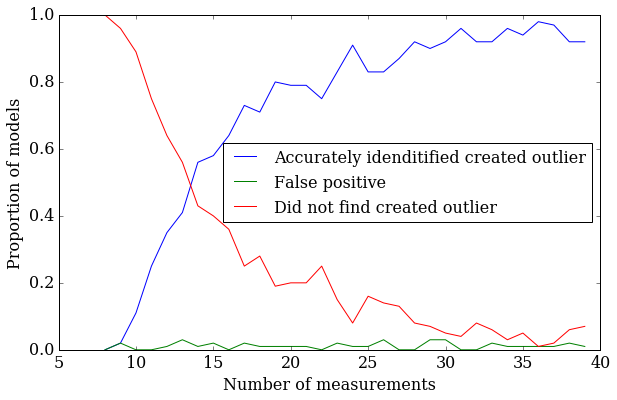

In [7]:
plt.figure(figsize=(6 * 1.618, 6))

plt.plot(amount_range, correct/n, label=r'Accurately idenditified created outlier')
plt.plot(amount_range, false_positive/n, label=r'False positive')
plt.plot(amount_range, not_found/n, label=r'Did not find created outlier')

plt.xlabel(r'Number of measurements')
plt.ylabel(r'Proportion of models')

plt.legend(loc='center right')